In [1]:
# https://github.com/meliketoy/wide-resnet.pytorch/blob/master/main.py
# cifar10, cifar100 training code reference  
# 2. High Resolution Classifier in yolov2
# Pretraining과 detection의 resolution이 맞아야 한다. (imagenet 224 -> 448 로 변경 후 약 4% map 증가)
# cifar로 pretraining하는 것 의미 없다.


In [2]:
import torch
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import time
import sys
from tqdm import tqdm
sys.path.append('../')

from model import Yolov1

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]) # meanstd transformation

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [5]:
learning_rate = 0.0005
# training_epochs = 15
# batch_size = 64

In [6]:
batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
# trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
# testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# next(iter(trainloader))

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [9]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

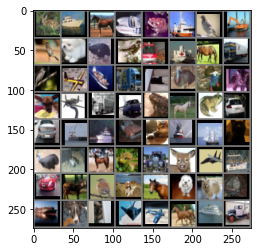

 deer  ship horse  ship  frog  ship  bird  ship  bird   dog  bird  bird truck  ship horse truck  bird plane  ship truck   cat  bird  bird   cat   dog plane truck   car  frog horse  frog   car   car  ship  ship   car   cat  ship  ship   cat  bird  frog horse  frog truck  deer plane  ship   car  deer  bird   dog horse   dog   dog   cat  ship   dog   cat plane plane horse  ship truck


In [10]:
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [11]:
model = Yolov1(split_size=25, num_boxes=2, num_classes=1, pretrain=True).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
#                                           batch_size=batch_size,
#                                           shuffle=True,
#                                           drop_last=True)
# total_batch = len(data_loader)
# print('총 배치의 수 : {}'.format(total_batch))

In [13]:
len(trainloader)

782

In [14]:
def test() :    
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images).squeeze()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        return 100 * correct / total

In [15]:
for epoch in range(10):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, 0)):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        model.train()
        inputs, labels = data
#         print(inputs.shape)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs).squeeze()
        
#         print(outputs.shape)
#         print(labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()

    print('epoch {} loss {}'.format(epoch, running_loss/len(trainloader)))
    print(test())
    running_loss = 0.0

print('Finished Training')

100%|██████████| 782/782 [00:34<00:00, 22.78it/s]

epoch 0 loss 1.7572666734380795



  0%|          | 0/782 [00:00<?, ?it/s]

35.33


100%|██████████| 782/782 [00:34<00:00, 22.92it/s]

epoch 1 loss 1.4125112056579736



  0%|          | 0/782 [00:00<?, ?it/s]

50.51


100%|██████████| 782/782 [00:35<00:00, 22.33it/s]

epoch 2 loss 1.219322661914484



  0%|          | 0/782 [00:00<?, ?it/s]

53.37


100%|██████████| 782/782 [00:35<00:00, 21.87it/s]

epoch 3 loss 1.1212939390593477



  0%|          | 0/782 [00:00<?, ?it/s]

62.54


100%|██████████| 782/782 [00:36<00:00, 21.49it/s]

epoch 4 loss 1.0375600637072493



  0%|          | 0/782 [00:00<?, ?it/s]

65.55


100%|██████████| 782/782 [00:39<00:00, 19.63it/s]

epoch 5 loss 0.9738944578353707



  0%|          | 0/782 [00:00<?, ?it/s]

67.69


 99%|█████████▉| 777/782 [00:40<00:00, 19.42it/s]


KeyboardInterrupt: 

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device).squeeze()
outputs = model(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images).squeeze()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
PATH = '../trained_model/cifar_net.pth'
torch.save(model.state_dict(), PATH)